In [1]:
import numpy as np
import pandas as pd
import scipy.special
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from IPython import display
from IPython.display import clear_output
import random
from sklearn.preprocessing import OneHotEncoder
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingLR

# Numbers dataset

In [2]:
df = pd.read_csv('.\\data\\MNIST_numbers\\data.csv')
train, test = train_test_split(df, random_state=42, train_size=0.8, shuffle=True)
train = train.reset_index()
test = test.reset_index()

train_x, train_y = train.iloc[:, 2:], train.iloc[:, 1]
test_x, test_y = test.iloc[:, 2:], test.iloc[:, 1]

train.head(5)

,index,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,34941,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,24433,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,24432,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8832,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,30291,7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


y = 6


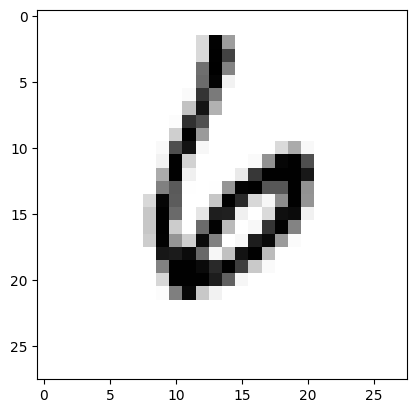

In [3]:
image_array = np.array(train_x.loc[0]).reshape((28,28))
print(f'y = {train_y.loc[0]}')
plt.imshow(image_array, cmap = 'Greys')

In [4]:
class NeuralNetwork:
  def __init__(self, eta=0.05, niter=1, inputnodes=784, hiddennodes_1=50, hiddennodes_2=50, outputnodes=10):
    # количество нейронов в входном слое
    self.inodes = inputnodes
    # количество нейронов в скрытом слое 1
    self.hnodes_1 = hiddennodes_1
    # количество нейронов в скрытом слое 2
    self.hnodes_2 = hiddennodes_2
    # количество нейронов в выходном слое
    self.onodes = outputnodes
    # весовые коэф. между входом и скрытым слоем
    self.w1 = np.random.normal(0.0 , pow(self.hnodes_1,-0.5), (self.hnodes_1, self.inodes))
    # весовые коэф. между скрытым и скрытым слоем
    self.w2 = np.random.normal(0.0 , pow(self.hnodes_2,-0.5), (self.hnodes_2, self.hnodes_1))
    # Весовые коэф. между скрытым слоем и выходом
    self.w3 = np.random.normal(0.0 , pow(self.onodes,-0.5), (self.onodes,self.hnodes_2))
    # скорость обучения
    self.eta = eta
    # сигмоида в качестве функции активации
    self.activation_function = lambda x: scipy.special.expit(x)
    # количество эпох обучения
    self.niter = niter
    pass

  def train(self, X, y):
    # преобразуем входые вектора признаков в двумерный массив
    X = np.array(X, ndmin=2).T
    # преобразуем вектор целевых значений в двумерный массив
    y = np.array(y, ndmin=2).T

    # Рассчитываем исходящие сигналы для скрытого слоя 1
    hidden_outputs_1 = self.activation_function(np.dot(self.w1,X))

    # Рассчитываем исходящие сигналы для скрытого слоя 2
    hidden_outputs_2 = self.activation_function(np.dot(self.w2,hidden_outputs_1))

    # рассчитываем выходные значения
    final_outputs = self.activation_function(np.dot(self.w3, hidden_outputs_2))

    # считаем ошибку выходного слоя (целевое - выходное)
    output_errors = y - final_outputs
    # обновляем  весовые коэф. для связей выходного
    self.w3 += self.eta * np.dot(output_errors * final_outputs * (1.0 - final_outputs),np.transpose(hidden_outputs_2))
      
    # ошибка скрытого слоя 2
    hidden_errors_2 = np.dot(self.w3.T,output_errors)
    # обновляем  весовые коэф. для связей скрытого слоя 2
    self.w2 += self.eta * np.dot(hidden_errors_2 * hidden_outputs_2 * (1.0 - hidden_outputs_2),np.transpose(hidden_outputs_1))

    # ошибка скрытого слоя 1
    hidden_errors_1 = np.dot(self.w2.T,hidden_errors_2)
    # обновляем  весовые коэф. для связей скрытого слоя 1
    self.w1 += self.eta * np.dot(hidden_errors_1 * hidden_outputs_1 * (1.0 - hidden_outputs_1),np.transpose(X))
    pass

  def predict(self, inputs_list):
    inputs = np.array(inputs_list, ndmin = 2).T
    # рассчитываем входящие сигналы для скрытого слоя 1
    hidden_outputs_1 = self.activation_function(np.dot(self.w1, inputs))
    # рассчитываем входящие сигналы для скрытого слоя 2
    hidden_outputs_2 = self.activation_function(np.dot(self.w2, hidden_outputs_1))
    # рассчитываем исходящие сигналы для выходного слоя
    final_outputs = self.activation_function(np.dot(self.w3, hidden_outputs_2))
    return final_outputs

In [5]:
input_nodes = 784
hidden_nodes_1 = 200
hidden_nodes_2 = 100
output_nodes = 10


eta = 0.06
n_iter = 100

n = NeuralNetwork(eta, n_iter, input_nodes, hidden_nodes_1, hidden_nodes_2, output_nodes,)

for idx in tqdm(train.index):
    X = list(train_x.loc[idx])
    y = train_y.loc[idx]
    inputs = (np.asfarray(X)/255.0)
    targets = np.zeros(output_nodes) + 0.01
    targets[y] = 0.99
    # shape(784, 10)
    n.train(inputs, targets)

100%|███████████████████████████████████████████████████████████████████████████| 33600/33600 [02:06<00:00, 265.17it/s]


predict_y = 
[[0.02982468]
 [0.00700193]
 [0.04911578]
 [0.0017745 ]
 [0.01065333]
 [0.00429068]
 [0.97040618]
 [0.01208757]
 [0.00787249]
 [0.00652172]]

target_y = 6


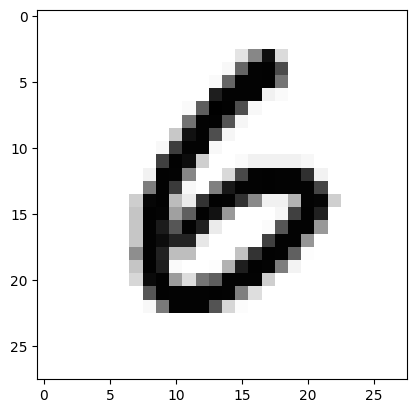

In [6]:
test_num = 5457
y = train_y.loc[test_num]
X = np.asfarray(list(train_x.loc[test_num]))
image_x = X.reshape((28,28))

predict_y = n.predict((np.asfarray(X)/255.0))
print(f'predict_y = \n{predict_y}')

print(f'\ntarget_y = {y}')
plt.imshow(image_x,cmap = 'Greys',interpolation='None')

In [7]:
scorecard = []
for idx in test_x.index:
    X = np.asfarray(test_x.loc[idx]/255.0)
    target_y = test_y.loc[idx]

    outputs = n.predict(X)
    pred_y = np.argmax(outputs)
    
    if (pred_y == target_y):
        scorecard.append(1)
    else:
        scorecard.append(0)

print(f'Sum of correct predictions: {sum(scorecard)}')
print(f'Sum of incorrect predictions: {len(scorecard) - sum(scorecard)}')
print(f'Percent of correct predictions: {int(sum(scorecard)*100/len(scorecard))}%')

Sum of correct predictions: 7908
Sum of incorrect predictions: 492
Percent of correct predictions: 94%


# Fashion dataset

In [2]:
fashion_train = pd.read_csv('.\\data\\MNIST_fashion\\train.csv')
fashion_test = pd.read_csv('.\\data\\MNIST_fashion\\test.csv')

fashion_train = fashion_train.sample(frac=1).reset_index(drop=True)
ftrain, fval = train_test_split(fashion_train, train_size=0.9, random_state=42)
ftrain = ftrain.reset_index()
fval = fval.reset_index()
ftest = fashion_test.reset_index()


ftrain_x, ftrain_y = ftrain.iloc[:, 2:], ftrain.iloc[:, 1]
ftest_x, ftest_y = ftest.iloc[:, 2:], ftest.iloc[:, 1]
fval_x, fval_y = fval.iloc[:, 2:], fval.iloc[:, 1]

num_classes = len(set(ftrain_y))

ftrain.head(5)

,index,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,50404,8,0,0,0,0,0,0,0,0,...,152,144,168,53,0,0,0,0,0,0
1,26810,7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,19681,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7616,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,20363,7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


y = 8


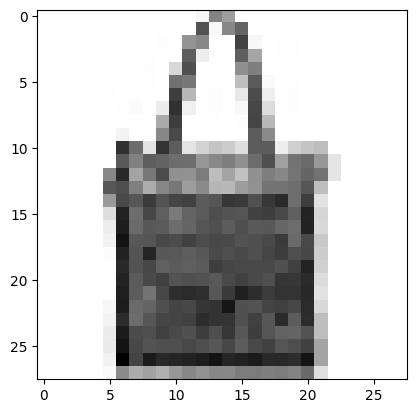

In [3]:
image_array = np.array(ftrain_x.loc[0]).reshape((28,28))
print(f'y = {ftrain_y.loc[0]}')
plt.imshow(image_array, cmap = 'Greys')

In [4]:
encoder_train = OneHotEncoder(categories='auto')
ftrain_y = encoder_train.fit_transform(ftrain_y.values.reshape(-1, 1)).toarray()

encoder_val = OneHotEncoder(categories='auto')
fval_y = encoder_val.fit_transform(fval_y.values.reshape(-1, 1)).toarray()

ftrain_y

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [5]:
ftrain_y.shape

(54000, 10)

In [13]:
class My_Neural_Network(nn.Module):
    def __init__(self, input_dim = 784, hidden_dim = 30, num_classes = 10):
        super(My_Neural_Network, self).__init__()
        self.in_dim = input_dim
        self.h_dim = hidden_dim
        self.out_dim = num_classes
        self.fc1 = nn.Linear(self.in_dim, self.h_dim)
        self.fc2 = nn.Linear(self.h_dim, self.h_dim//2)
        self.fc3 = nn.Linear(self.h_dim//2, self.h_dim//4)
        self.fc4 = nn.Linear(self.h_dim//4, self.out_dim)
        #self.dropout = nn.Dropout()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

    def forward(self, x: torch.Tensor):
        fc1 = self.relu(self.fc1(x))
        fc2 = self.relu(self.fc2(fc1))
        fc3 = self.relu(self.fc3(fc2))
        logits = self.softmax(self.fc4(fc3))
        return logits

    def predict(self, x):
        fc1 = self.relu(self.fc1(x))
        fc2 = self.relu(self.fc2(fc1))
        fc3 = self.relu(self.fc3(fc2))
        logits = self.softmax(self.fc4(fc3))
        output = torch.argmax(logits, dim=1)
        return output

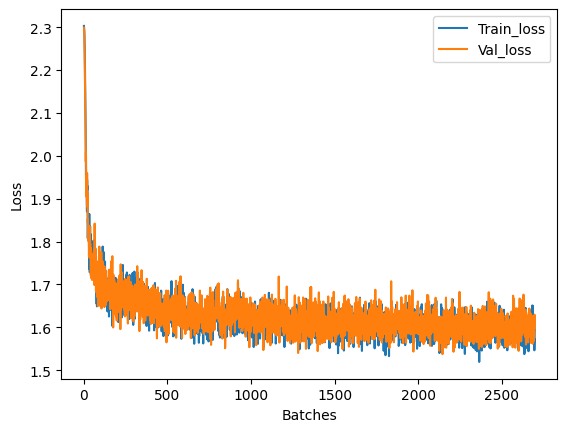

100%|████████████████████████████████████████████████████████████████████████████████| 270/270 [01:12<00:00,  3.72it/s]


In [26]:
input_dim = 784
hidden_dim = 700

fmodel = My_Neural_Network(input_dim, hidden_dim, num_classes)

learning_rate = 0.001
epoches = 10
batch_size = 200

c = 0
count = []
losses = []
val_losses = []

optimizer = optim.Adam(fmodel.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, 1650*epoches)

for epoch in range(epoches):
    fmodel.train()
    for i in tqdm(range(int(len(ftrain_x.values)/batch_size))):
        x = ftrain_x.values[i * batch_size : (i+1) * batch_size]
        y = ftrain_y[i * batch_size : (i+1) * batch_size]

        input = torch.tensor(x)/255.0
        target_y = torch.tensor(y)

        optimizer.zero_grad()
        
        # torch.Size([batch, 784])
        output = fmodel(input)
        # torch.Size([batch, num_classes]) torch.Size([batch, num_classes])
        loss = criterion(output, target_y)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        losses.append(loss.item())
        count.append(c)
        c += 1

        with torch.no_grad():
            indexes = random.sample(list(fval_x.index), batch_size)
            x = [fval_x.values[i] for i in sorted(indexes)]
            y = [fval_y[i] for i in sorted(indexes)]

            input = torch.tensor(x)/255.0
            target_y = torch.tensor(y) 

            # torch.Size([batch, 784])
            val_output = fmodel(input)
            # torch.Size([batch, num_classes]) torch.Size([batch, num_classes])
            val_loss = criterion(val_output, target_y)
            val_losses.append(val_loss.item())
        
        
        display.clear_output(wait=True)
        plt.plot(count, losses, label='Train_loss') 
        plt.plot(count, val_losses, label='Val_loss')
        plt.legend()
        plt.xlabel('Batches')
        plt.ylabel('Loss')
        plt.show()

# save weights
torch.save(fmodel.state_dict(), "fashion_model.pt")

In [27]:
# fmodel = My_Neural_Network(input_dim, hidden_dim, num_classes)
fmodel.load_state_dict(torch.load("fashion_model.pt"))
index = 1020

# shape: ([1, 784])
x = torch.tensor(ftest_x.values[index]).unsqueeze(0)/255.0
print(f'Predict_y = {fmodel.predict(x)}')
print(f'Target_y = {ftest_y.values[index]}')

Predict_y = tensor([8])
Target_y = 8


C:\Users\Chiki\AppData\Local\Temp\ipykernel_4216\3233327213.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = self.softmax(self.fc4(fc3))


In [28]:
fscorecard = []
for idx in ftest_x.index:
    x = torch.tensor(ftest_x.values[idx]).unsqueeze(0)/255.0
    target_y = ftest_y.values[idx]
    pred_y = fmodel.predict(x)

    if (pred_y == target_y):
        fscorecard.append(1)
    else:
        fscorecard.append(0)

print(f'Sum of correct predictions: {sum(fscorecard)}')
print(f'Sum of incorrect predictions: {len(fscorecard) - sum(fscorecard)}')
print(f'Percent of correct predictions: {int(sum(fscorecard)*100/len(fscorecard))}%')

C:\Users\Chiki\AppData\Local\Temp\ipykernel_4216\3233327213.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = self.softmax(self.fc4(fc3))


Sum of correct predictions: 8684
Sum of incorrect predictions: 1316
Percent of correct predictions: 86%
